# Autoregressive Transformer in Pytorch

similar to GPT architecture
https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf

some differences: RELU instead of GELU

Trained on WMT since this was the dataset used by the original Attention is all you need paper, and the decoder module used is shared with that architecture

Data was downloaded manually from https://nlp.stanford.edu/projects/nmt/ since torchnlp seems to be broken

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
from collections import OrderedDict
from functools import partial
import importlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from src import data
from src import torch_models as models
from src import train_utils
import src.utils as utils

# reload during active development
importlib.reload(data)
importlib.reload(models)

<module 'src.torch_models' from '/mnt/ml_implementations/torch/attention/src/torch_models.py'>

In [4]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Train tokenizer using BBPE

"Sentences were encoded using byte-pair encoding [3], which has a shared sourcetarget vocabulary of about 37000 tokens"

Use tokenizers from huggingface

In [5]:
train_path_en = 'data/train.en'
train_path_de = 'data/train.de'
tokenizer_path = "data/tokenizer-bbpe-joint.json"

In [6]:
bbpe = data.get_bbpe_tokenizer(tokenizer_path, data_file_list=[train_path_en, train_path_de])

INFO:root:loading BBPE tokenizer at data/tokenizer-bbpe-joint.json


In [7]:
encoding = bbpe.encode(
    'this is a test sentence for byte pair encoding outofvocabword')
print(encoding.ids)
bbpe.decode(encoding.ids)

[3120, 336, 1818, 267, 21573, 277, 3099, 1019, 1203, 4027, 286, 10936, 316, 22466, 1014, 512, 6690, 9969, 85, 2143, 536, 24299]


'this is a test sentence for byte pair encoding outofvocabword'

## Build Model

### Small model for testing

In [8]:
importlib.reload(models)
importlib.reload(train_utils)
max_seqlen = 64
model_config = models.ModelConfig(
    dim=512,
    N=2,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_seqlen,
    drop_rate=0.01,
    position_encoding_class=models.LearnablePositionalEncoding,
)

model_config_large = models.ModelConfig(
    dim=512,
    N=8,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_seqlen,
    drop_rate=0.01,
    position_encoding_class=models.LearnablePositionalEncoding,
)

In [9]:
# for testing
seqlen = 22
tokens = [1] * seqlen
tokens = torch.tensor(tokens).unsqueeze(0)

In [10]:
model_autoreg = models.Autoregressive.from_config(model_config)
_ = model_autoreg.apply(train_utils.init_ones)
model_autoreg(tokens)

tensor([[[409.7980, 409.7980, 409.7980,  ..., 409.7979, 409.7979, 409.7979],
         [539.5802, 539.5802, 539.5802,  ..., 539.5815, 539.5815, 539.5815],
         [454.0135, 454.0135, 454.0135,  ..., 454.0151, 454.0151, 454.0151],
         ...,
         [599.6292, 599.6292, 599.6292,  ..., 599.6282, 599.6282, 599.6282],
         [478.8693, 478.8693, 478.8693,  ..., 478.8710, 478.8710, 478.8710],
         [466.7212, 466.7212, 466.7212,  ..., 466.7206, 466.7206, 466.7206]]],
       grad_fn=<AddBackward0>)

###  min gpt as control

https://github.com/karpathy/minGPT

Compare output with minGPT to make sure everything is working as expected

In [11]:
from src.minGPT.mingpt import model as min_gpt
from src.minGPT.mingpt.trainer import Trainer, TrainerConfig

In [12]:
#tconf = TrainerConfig(max_epochs=10, batch_size=256)
#trainer = Trainer(model, train_gen, train_gen, tconf)
#trainer.train()

mconf = min_gpt.GPTConfig(bbpe.get_vocab_size(),
                          model_config.max_context,
                          n_layer=model_config.N,
                          n_head=model_config.h,
                          n_embd=model_config.dim)
mgmodel = min_gpt.GPT(mconf)

INFO:src.minGPT.mingpt.model:number of parameters: 3.706163e+07


In [13]:
mgmodel.load_state_dict(torch.load(f'./saved_models/mingpt_n2_h8_d512_c64/1400'))

<All keys matched successfully>

In [14]:
print('Number of params in min GPT:', sum(p.numel() for p in mgmodel.parameters()))

Number of params in min GPT: 37061632


In [16]:
print('Number of params in implementation:', sum(p.numel() for p in model_autoreg.parameters()))

Number of params in implementation: 37087539


## Data Pipelines

In [15]:
if 'train_lines' not in locals():
    train_lines = sum(1 for line in open(data.TRAIN_PATH_EN, encoding='utf-8'))
if 'test_lines' not in locals():
    test_lines = sum(1 for line in open(data.TEST_PATH_EN, encoding='utf-8'))
print(f'train lines: {train_lines}')
print(f'test lines: {test_lines}')

train lines: 4468840
test lines: 2737


In [16]:
os.cpu_count()

48

### training/ data params

docs: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [53]:
importlib.reload(data)
dataset_config = data.DatasetConfig(bbpe, model_config_large.max_context)
tok_fn = partial(data.str_to_tok, add_start=False)
tok_fn_w_start = partial(data.str_to_tok, add_start=True)

def input_fn(en_line, de_line, data_config):
    en_input = data.str_to_tok(en_line, data_config, add_start=True)
    return [en_input]

def target_fn(en_line, de_line, data_config):
    return data.str_to_tok(en_line, data_config, add_start=False)

batch_size = 64

 Training would be more efficient with seqlen-aware batching, but for now a first order implementation is sufficient

In [50]:
# autoregressive training
importlib.reload(data)

train_dataset_autoreg = data.WMT2014Mixing(
    num_pools=7919,  # pick a prime number
    start_line=0,
    end_line=train_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=True,
    overwrite_de_path=data.TRAIN_PATH_EN,
)
train_loader_autoreg = torch.utils.data.DataLoader(
    train_dataset_autoreg,
    batch_size=batch_size,
    pin_memory=True,
)

test_dataset_autoreg = data.WMT2014Mixing(
    num_pools=101,  # pick a prime number
    start_line=0,
    end_line=test_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=False,
    overwrite_de_path=data.TEST_PATH_EN,
)
test_loader_autoreg = torch.utils.data.DataLoader(
    test_dataset_autoreg,
    batch_size=batch_size,
    pin_memory=True,
)

INFO:root:Loading existing line breaks for file data/train.en at data/train.en_linebreaks.pickle
INFO:root:Loading existing line breaks for file data/train.en at data/train.en_linebreaks.pickle
INFO:root:IterShuffleMixin: Initializing 7919 pools with 564 lines per pool
INFO:root:Loading existing line breaks for file data/test/newstest2014.en at data/test/newstest2014.en_linebreaks.pickle
INFO:root:Loading existing line breaks for file data/test/newstest2014.en at data/test/newstest2014.en_linebreaks.pickle
INFO:root:IterShuffleMixin: Initializing 101 pools with 27 lines per pool


## Training

Paper uses:

- emb_dimension, attn_dimension = 512
- n_heads = 8
- p_drop = 0.1
- N = 6
- train steps 100k

We have less compute so need to scale down the model to fit on one GPU

In [51]:
#loss_histories = dict()
with open('./saved_models/loss_histories.pickle', 'rb') as f:
    loss_histories = pickle.load(f)
loss_histories.keys()

dict_keys(['mingpt_n2_h8_d512_c64', 'autoreg_n2_h8_d512_c64_wproj_xavier', 'autoreg_n2_h8_d512_c64_wproj_mingptinit', 'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe', 'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle', 'autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle'])

In [23]:
importlib.reload(train_utils)
importlib.reload(data)

_ = model_autoreg.apply(train_utils.min_gpt_init_weights)
train_utils.train_autoregressive(
    model_autoreg,
    loss_histories,
    'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle',
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
)

INFO:root:saving models to ./saved_models/autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle
INFO:root:Reading files data/train.en, data/train.en at position 4069824
INFO:root:Reading files data/train.en, data/train.en at position 1788444
INFO:root:Reading files data/train.en, data/train.en at position 631680
INFO:root:Reading files data/train.en, data/train.en at position 2397000
INFO:root:Reading files data/train.en, data/train.en at position 2987508
INFO:root:Reading files data/train.en, data/train.en at position 163560
INFO:root:Reading files data/train.en, data/train.en at position 2303376
INFO:root:Reading files data/train.en, data/train.en at position 2985252
INFO:root:Reading files data/train.en, data/train.en at position 4073772
INFO:root:Reading files data/train.en, data/train.en at position 2166324
INFO:root:Reading files data/train.en, data/train.en at position 4445448
INFO:root:Reading files data/train.en, data/train.en at position 4387356
INFO:root:Reading files 

INFO:root:Reading files data/train.en, data/train.en at position 342348
INFO:root:Reading files data/train.en, data/train.en at position 2963820
INFO:root:Reading files data/train.en, data/train.en at position 622092
INFO:root:Reading files data/train.en, data/train.en at position 3682356
INFO:root:Reading files data/train.en, data/train.en at position 805392
INFO:root:Reading files data/train.en, data/train.en at position 424128
INFO:root:Reading files data/train.en, data/train.en at position 2991456
INFO:root:Reading files data/train.en, data/train.en at position 3744960
INFO:root:Reading files data/train.en, data/train.en at position 645216
INFO:root:Reading files data/train.en, data/train.en at position 1033812
INFO:root:Reading files data/train.en, data/train.en at position 10152
INFO:root:Reading files data/train.en, data/train.en at position 280308
INFO:root:Reading files data/train.en, data/train.en at position 2649672
INFO:root:Reading files data/train.en, data/train.en at pos

0 10.322539329528809


INFO:root:Reading files data/train.en, data/train.en at position 3929952
INFO:root:Reading files data/train.en, data/train.en at position 1677900
INFO:root:Reading files data/train.en, data/train.en at position 4392432
INFO:root:Reading files data/train.en, data/train.en at position 3531768
INFO:root:Reading files data/train.en, data/train.en at position 2086236
INFO:root:Reading files data/train.en, data/train.en at position 1148304
INFO:root:Reading files data/train.en, data/train.en at position 493500
INFO:root:Reading files data/train.en, data/train.en at position 3148812
INFO:root:Reading files data/train.en, data/train.en at position 3444912
INFO:root:Reading files data/train.en, data/train.en at position 4139196
INFO:root:Reading files data/train.en, data/train.en at position 4191648
INFO:root:Reading files data/train.en, data/train.en at position 2827332
INFO:root:Reading files data/train.en, data/train.en at position 1379544
INFO:root:Reading files data/train.en, data/train.en

INFO:root:Reading files data/train.en, data/train.en at position 4195032
INFO:root:Reading files data/train.en, data/train.en at position 1268436
INFO:root:Reading files data/train.en, data/train.en at position 468684
INFO:root:Reading files data/train.en, data/train.en at position 2171964
INFO:root:Reading files data/train.en, data/train.en at position 2984124
INFO:root:Reading files data/train.en, data/train.en at position 3825048
INFO:root:Reading files data/train.en, data/train.en at position 1888272
INFO:root:Reading files data/train.en, data/train.en at position 541440
INFO:root:Reading files data/train.en, data/train.en at position 4131864
INFO:root:Reading files data/train.en, data/train.en at position 1311300
INFO:root:Reading files data/train.en, data/train.en at position 2596656
INFO:root:Reading files data/train.en, data/train.en at position 4463496
INFO:root:Reading files data/train.en, data/train.en at position 239136
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 1275768
INFO:root:Reading files data/train.en, data/train.en at position 3210288
INFO:root:Reading files data/train.en, data/train.en at position 1611912
INFO:root:Reading files data/train.en, data/train.en at position 4243536
INFO:root:Reading files data/train.en, data/train.en at position 86856
INFO:root:Reading files data/train.en, data/train.en at position 3342828
INFO:root:Reading files data/train.en, data/train.en at position 3081696
INFO:root:Reading files data/train.en, data/train.en at position 3670512
INFO:root:Reading files data/train.en, data/train.en at position 1950312
INFO:root:Reading files data/train.en, data/train.en at position 2586504
INFO:root:Reading files data/train.en, data/train.en at position 1391952
INFO:root:Reading files data/train.en, data/train.en at position 571332
INFO:root:Reading files data/train.en, data/train.en at position 1868532
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 3135276
INFO:root:Reading files data/train.en, data/train.en at position 785652
INFO:root:Reading files data/train.en, data/train.en at position 2662080
INFO:root:Reading files data/train.en, data/train.en at position 4174164
INFO:root:Reading files data/train.en, data/train.en at position 1475424
INFO:root:Reading files data/train.en, data/train.en at position 3201828
INFO:root:Reading files data/train.en, data/train.en at position 2003892
INFO:root:Reading files data/train.en, data/train.en at position 2866248
INFO:root:Reading files data/train.en, data/train.en at position 1378980
INFO:root:Reading files data/train.en, data/train.en at position 4364796
INFO:root:Reading files data/train.en, data/train.en at position 1816080
INFO:root:Reading files data/train.en, data/train.en at position 2019684
INFO:root:Reading files data/train.en, data/train.en at position 335580
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 3921492
INFO:root:Reading files data/train.en, data/train.en at position 57528
INFO:root:Reading files data/train.en, data/train.en at position 632244
INFO:root:Reading files data/train.en, data/train.en at position 1820028
INFO:root:Reading files data/train.en, data/train.en at position 3686304
INFO:root:Reading files data/train.en, data/train.en at position 2892756
INFO:root:Reading files data/train.en, data/train.en at position 401004
INFO:root:Reading files data/train.en, data/train.en at position 732636
INFO:root:Reading files data/train.en, data/train.en at position 346296
INFO:root:Reading files data/train.en, data/train.en at position 1140408
INFO:root:Reading files data/train.en, data/train.en at position 3421788
INFO:root:Reading files data/train.en, data/train.en at position 725868
INFO:root:Reading files data/train.en, data/train.en at position 896196
INFO:root:Reading files data/train.en, data/train.en at pos

INFO:root:Reading files data/train.en, data/train.en at position 2778264
INFO:root:Reading files data/train.en, data/train.en at position 2649108
INFO:root:Reading files data/train.en, data/train.en at position 4166268
INFO:root:Reading files data/train.en, data/train.en at position 2761908
INFO:root:Reading files data/train.en, data/train.en at position 2355828
INFO:root:Reading files data/train.en, data/train.en at position 1955952
INFO:root:Reading files data/train.en, data/train.en at position 4050648
INFO:root:Reading files data/train.en, data/train.en at position 1194552
INFO:root:Reading files data/train.en, data/train.en at position 3963228
INFO:root:Reading files data/train.en, data/train.en at position 354756
INFO:root:Reading files data/train.en, data/train.en at position 2486676
INFO:root:Reading files data/train.en, data/train.en at position 3581400
INFO:root:Reading files data/train.en, data/train.en at position 1982460
INFO:root:Reading files data/train.en, data/train.en

INFO:root:Reading files data/train.en, data/train.en at position 1349652
INFO:root:Reading files data/train.en, data/train.en at position 3948000
INFO:root:Reading files data/train.en, data/train.en at position 3153888
INFO:root:Reading files data/train.en, data/train.en at position 942444
INFO:root:Reading files data/train.en, data/train.en at position 765912
INFO:root:Reading files data/train.en, data/train.en at position 2266716
INFO:root:Reading files data/train.en, data/train.en at position 219960
INFO:root:Reading files data/train.en, data/train.en at position 51324
INFO:root:Reading files data/train.en, data/train.en at position 1908012
INFO:root:Reading files data/train.en, data/train.en at position 1210908
INFO:root:Reading files data/train.en, data/train.en at position 1218804
INFO:root:Reading files data/train.en, data/train.en at position 4262712
INFO:root:Reading files data/train.en, data/train.en at position 3832944
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 4369308
INFO:root:Reading files data/train.en, data/train.en at position 972900
INFO:root:Reading files data/train.en, data/train.en at position 3864528
INFO:root:Reading files data/train.en, data/train.en at position 3212544
INFO:root:Reading files data/train.en, data/train.en at position 4419504
INFO:root:Reading files data/train.en, data/train.en at position 84036
INFO:root:Reading files data/train.en, data/train.en at position 3918108
INFO:root:Reading files data/train.en, data/train.en at position 2918136
INFO:root:Reading files data/train.en, data/train.en at position 4045572
INFO:root:Reading files data/train.en, data/train.en at position 3797412
INFO:root:Reading files data/train.en, data/train.en at position 1479372
INFO:root:Reading files data/train.en, data/train.en at position 2160120
INFO:root:Reading files data/train.en, data/train.en at position 113364
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 1675080
INFO:root:Reading files data/train.en, data/train.en at position 1746144
INFO:root:Reading files data/train.en, data/train.en at position 1864584
INFO:root:Reading files data/train.en, data/train.en at position 1368828
INFO:root:Reading files data/train.en, data/train.en at position 3531204
INFO:root:Reading files data/train.en, data/train.en at position 3948
INFO:root:Reading files data/train.en, data/train.en at position 1752912
INFO:root:Reading files data/train.en, data/train.en at position 4094640
INFO:root:Reading files data/train.en, data/train.en at position 4327572
INFO:root:Reading files data/train.en, data/train.en at position 2706636
INFO:root:Reading files data/train.en, data/train.en at position 2155608
INFO:root:Reading files data/train.en, data/train.en at position 4077156
INFO:root:Reading files data/train.en, data/train.en at position 77832
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 308508
INFO:root:Reading files data/train.en, data/train.en at position 3834636
INFO:root:Reading files data/train.en, data/train.en at position 3534024
INFO:root:Reading files data/train.en, data/train.en at position 25380
INFO:root:Reading files data/train.en, data/train.en at position 3078876
INFO:root:Reading files data/train.en, data/train.en at position 1452864
INFO:root:Reading files data/train.en, data/train.en at position 3266688
INFO:root:Reading files data/train.en, data/train.en at position 843744
INFO:root:Reading files data/train.en, data/train.en at position 2598348
INFO:root:Reading files data/train.en, data/train.en at position 3252024
INFO:root:Reading files data/train.en, data/train.en at position 555540
INFO:root:Reading files data/train.en, data/train.en at position 3145428
INFO:root:Reading files data/train.en, data/train.en at position 2020812
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 3362568
INFO:root:Reading files data/train.en, data/train.en at position 1923804
INFO:root:Reading files data/train.en, data/train.en at position 1080060
INFO:root:Reading files data/train.en, data/train.en at position 1481628
INFO:root:Reading files data/train.en, data/train.en at position 1995432
INFO:root:Reading files data/train.en, data/train.en at position 2810976
INFO:root:Reading files data/train.en, data/train.en at position 3319704
INFO:root:Reading files data/train.en, data/train.en at position 3311244
INFO:root:Reading files data/train.en, data/train.en at position 650292
INFO:root:Reading files data/train.en, data/train.en at position 2250360
INFO:root:Reading files data/train.en, data/train.en at position 3857760
INFO:root:Reading files data/train.en, data/train.en at position 1776036
INFO:root:Reading files data/train.en, data/train.en at position 213756
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 4002144
INFO:root:Reading files data/train.en, data/train.en at position 2887680
INFO:root:Reading files data/train.en, data/train.en at position 3499056
INFO:root:Reading files data/train.en, data/train.en at position 326556
INFO:root:Reading files data/train.en, data/train.en at position 643524
INFO:root:Reading files data/train.en, data/train.en at position 393672
INFO:root:Reading files data/train.en, data/train.en at position 939624
INFO:root:Reading files data/train.en, data/train.en at position 710640
INFO:root:Reading files data/train.en, data/train.en at position 3247512
INFO:root:Reading files data/train.en, data/train.en at position 3764700
INFO:root:Reading files data/train.en, data/train.en at position 528468
INFO:root:Reading files data/train.en, data/train.en at position 1431432
INFO:root:Reading files data/train.en, data/train.en at position 3641184
INFO:root:Reading files data/train.en, data/train.en at p

INFO:root:Reading files data/train.en, data/train.en at position 4030344
INFO:root:Reading files data/train.en, data/train.en at position 3681228
INFO:root:Reading files data/train.en, data/train.en at position 965568
INFO:root:Reading files data/train.en, data/train.en at position 113928
INFO:root:Reading files data/train.en, data/train.en at position 3377232
INFO:root:Reading files data/train.en, data/train.en at position 2480472
INFO:root:Reading files data/train.en, data/train.en at position 3993684
INFO:root:Reading files data/train.en, data/train.en at position 481656
INFO:root:Reading files data/train.en, data/train.en at position 217140
INFO:root:Reading files data/train.en, data/train.en at position 2077212
INFO:root:Reading files data/train.en, data/train.en at position 2284764
INFO:root:Reading files data/train.en, data/train.en at position 2957616
INFO:root:Reading files data/train.en, data/train.en at position 2988636
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 2830152
INFO:root:Reading files data/train.en, data/train.en at position 2571840
INFO:root:Reading files data/train.en, data/train.en at position 265080
INFO:root:Reading files data/train.en, data/train.en at position 1250952
INFO:root:Reading files data/train.en, data/train.en at position 873636
INFO:root:Reading files data/train.en, data/train.en at position 1418460
INFO:root:Reading files data/train.en, data/train.en at position 199656
INFO:root:Reading files data/train.en, data/train.en at position 3641748
INFO:root:Reading files data/train.en, data/train.en at position 4075464
INFO:root:Reading files data/train.en, data/train.en at position 1997688
INFO:root:Reading files data/train.en, data/train.en at position 1783368
INFO:root:Reading files data/train.en, data/train.en at position 4130736
INFO:root:Reading files data/train.en, data/train.en at position 3358620
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 585996
INFO:root:Reading files data/train.en, data/train.en at position 972336
INFO:root:Reading files data/train.en, data/train.en at position 784524
INFO:root:Reading files data/train.en, data/train.en at position 2014044
INFO:root:Reading files data/train.en, data/train.en at position 4435860
INFO:root:Reading files data/train.en, data/train.en at position 2628240
INFO:root:Reading files data/train.en, data/train.en at position 1283100
INFO:root:Reading files data/train.en, data/train.en at position 1818336
INFO:root:Reading files data/train.en, data/train.en at position 1940160
INFO:root:Reading files data/train.en, data/train.en at position 2131356
INFO:root:Reading files data/train.en, data/train.en at position 1914780
INFO:root:Reading files data/train.en, data/train.en at position 3950256
INFO:root:Reading files data/train.en, data/train.en at position 1193424
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 3532896
INFO:root:Reading files data/train.en, data/train.en at position 2506416
INFO:root:Reading files data/train.en, data/train.en at position 2753448
INFO:root:Reading files data/train.en, data/train.en at position 3074364
INFO:root:Reading files data/train.en, data/train.en at position 3236796
INFO:root:Reading files data/train.en, data/train.en at position 3554328
INFO:root:Reading files data/train.en, data/train.en at position 3206904
INFO:root:Reading files data/train.en, data/train.en at position 4217592
INFO:root:Reading files data/train.en, data/train.en at position 3163476
INFO:root:Reading files data/train.en, data/train.en at position 3405432
INFO:root:Reading files data/train.en, data/train.en at position 2462988
INFO:root:Reading files data/train.en, data/train.en at position 3673332
INFO:root:Reading files data/train.en, data/train.en at position 777756
INFO:root:Reading files data/train.en, data/train.en

INFO:root:Reading files data/train.en, data/train.en at position 4413300
INFO:root:Reading files data/train.en, data/train.en at position 610248
INFO:root:Reading files data/train.en, data/train.en at position 976284
INFO:root:Reading files data/train.en, data/train.en at position 124080
INFO:root:Reading files data/train.en, data/train.en at position 90804
INFO:root:Reading files data/train.en, data/train.en at position 1006740
INFO:root:Reading files data/train.en, data/train.en at position 2977356
INFO:root:Reading files data/train.en, data/train.en at position 1938468
INFO:root:Reading files data/train.en, data/train.en at position 3875808
INFO:root:Reading files data/train.en, data/train.en at position 1332732
INFO:root:Reading files data/train.en, data/train.en at position 1164660
INFO:root:Reading files data/train.en, data/train.en at position 11844
INFO:root:Reading files data/train.en, data/train.en at position 3939540
INFO:root:Reading files data/train.en, data/train.en at po

INFO:root:Reading files data/train.en, data/train.en at position 3889908
INFO:root:Reading files data/train.en, data/train.en at position 1662108
INFO:root:Reading files data/train.en, data/train.en at position 3916416
INFO:root:Reading files data/train.en, data/train.en at position 3474804
INFO:root:Reading files data/train.en, data/train.en at position 4068696
INFO:root:Reading files data/train.en, data/train.en at position 869124
INFO:root:Reading files data/train.en, data/train.en at position 1500804
INFO:root:Reading files data/train.en, data/train.en at position 3374976
INFO:root:Reading files data/train.en, data/train.en at position 1838640
INFO:root:Reading files data/train.en, data/train.en at position 1334988
INFO:root:Reading files data/train.en, data/train.en at position 1859508
INFO:root:Reading files data/train.en, data/train.en at position 4288092
INFO:root:Reading files data/train.en, data/train.en at position 900708
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 3221004
INFO:root:Reading files data/train.en, data/train.en at position 2742732
INFO:root:Reading files data/train.en, data/train.en at position 36096
INFO:root:Reading files data/train.en, data/train.en at position 1503624
INFO:root:Reading files data/train.en, data/train.en at position 3326472
INFO:root:Reading files data/train.en, data/train.en at position 2652492
INFO:root:Reading files data/train.en, data/train.en at position 1931136
INFO:root:Reading files data/train.en, data/train.en at position 4173600
INFO:root:Reading files data/train.en, data/train.en at position 4267788
INFO:root:Reading files data/train.en, data/train.en at position 1169736
INFO:root:Reading files data/train.en, data/train.en at position 4225488
INFO:root:Reading files data/train.en, data/train.en at position 2585940
INFO:root:Reading files data/train.en, data/train.en at position 1713996
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 652548
INFO:root:Reading files data/train.en, data/train.en at position 345168
INFO:root:Reading files data/train.en, data/train.en at position 1457376
INFO:root:Reading files data/train.en, data/train.en at position 1527876
INFO:root:Reading files data/train.en, data/train.en at position 4409916
INFO:root:Reading files data/train.en, data/train.en at position 3300528
INFO:root:Reading files data/train.en, data/train.en at position 579228
INFO:root:Reading files data/train.en, data/train.en at position 1812696
INFO:root:Reading files data/train.en, data/train.en at position 1074420
INFO:root:Reading files data/train.en, data/train.en at position 737712
INFO:root:Reading files data/train.en, data/train.en at position 3052368
INFO:root:Reading files data/train.en, data/train.en at position 1003920
INFO:root:Reading files data/train.en, data/train.en at position 347988
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 936804
INFO:root:Reading files data/train.en, data/train.en at position 4382844
INFO:root:Reading files data/train.en, data/train.en at position 2501340
INFO:root:Reading files data/train.en, data/train.en at position 3283608
INFO:root:Reading files data/train.en, data/train.en at position 655368
INFO:root:Reading files data/train.en, data/train.en at position 1499112
INFO:root:Reading files data/train.en, data/train.en at position 2609628
INFO:root:Reading files data/train.en, data/train.en at position 1052424
INFO:root:Reading files data/train.en, data/train.en at position 3579144
INFO:root:Reading files data/train.en, data/train.en at position 3518232
INFO:root:Reading files data/train.en, data/train.en at position 2994276
INFO:root:Reading files data/train.en, data/train.en at position 610812
INFO:root:Reading files data/train.en, data/train.en at position 306252
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 3812640
INFO:root:Reading files data/train.en, data/train.en at position 2992584
INFO:root:Reading files data/train.en, data/train.en at position 443304
INFO:root:Reading files data/train.en, data/train.en at position 1322016
INFO:root:Reading files data/train.en, data/train.en at position 2579172
INFO:root:Reading files data/train.en, data/train.en at position 2345676
INFO:root:Reading files data/train.en, data/train.en at position 2029836
INFO:root:Reading files data/train.en, data/train.en at position 1817208
INFO:root:Reading files data/train.en, data/train.en at position 1896168
INFO:root:Reading files data/train.en, data/train.en at position 2214828
INFO:root:Reading files data/train.en, data/train.en at position 2998788
INFO:root:Reading files data/train.en, data/train.en at position 355884
INFO:root:Reading files data/train.en, data/train.en at position 2824512
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 3255408
INFO:root:Reading files data/train.en, data/train.en at position 4010604
INFO:root:Reading files data/train.en, data/train.en at position 1435380
INFO:root:Reading files data/train.en, data/train.en at position 1824540
INFO:root:Reading files data/train.en, data/train.en at position 2759652
INFO:root:Reading files data/train.en, data/train.en at position 3301092
INFO:root:Reading files data/train.en, data/train.en at position 1772088
INFO:root:Reading files data/train.en, data/train.en at position 672288
INFO:root:Reading files data/train.en, data/train.en at position 3217056
INFO:root:Reading files data/train.en, data/train.en at position 3511464
INFO:root:Reading files data/train.en, data/train.en at position 371112
INFO:root:Reading files data/train.en, data/train.en at position 3565044
INFO:root:Reading files data/train.en, data/train.en at position 4083924
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 1294380
INFO:root:Reading files data/train.en, data/train.en at position 4160064
INFO:root:Reading files data/train.en, data/train.en at position 3000480
INFO:root:Reading files data/train.en, data/train.en at position 3055188
INFO:root:Reading files data/train.en, data/train.en at position 4240152
INFO:root:Reading files data/train.en, data/train.en at position 1560588
INFO:root:Reading files data/train.en, data/train.en at position 4235076
INFO:root:Reading files data/train.en, data/train.en at position 3403740
INFO:root:Reading files data/train.en, data/train.en at position 2849328
INFO:root:Reading files data/train.en, data/train.en at position 2027016
INFO:root:Reading files data/train.en, data/train.en at position 2235132
INFO:root:Reading files data/train.en, data/train.en at position 4219284
INFO:root:Reading files data/train.en, data/train.en at position 2443248
INFO:root:Reading files data/train.en, data/train.e

20 7.061182022094727


INFO:root:Reading files data/train.en, data/train.en at position 1109388
INFO:root:Reading files data/train.en, data/train.en at position 3672768
INFO:root:Reading files data/train.en, data/train.en at position 1964412
INFO:root:Reading files data/train.en, data/train.en at position 1994868
INFO:root:Reading files data/train.en, data/train.en at position 2840868
INFO:root:Reading files data/train.en, data/train.en at position 278616
INFO:root:Reading files data/train.en, data/train.en at position 3486084
INFO:root:Reading files data/train.en, data/train.en at position 3440400
INFO:root:Reading files data/train.en, data/train.en at position 2901780
INFO:root:Reading files data/train.en, data/train.en at position 1512648
INFO:root:Reading files data/train.en, data/train.en at position 3926568
INFO:root:Reading files data/train.en, data/train.en at position 4167396
INFO:root:Reading files data/train.en, data/train.en at position 674544
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 2929416
INFO:root:Reading files data/train.en, data/train.en at position 2715096
INFO:root:Reading files data/train.en, data/train.en at position 1716816
INFO:root:Reading files data/train.en, data/train.en at position 3595500
INFO:root:Reading files data/train.en, data/train.en at position 2631624
INFO:root:Reading files data/train.en, data/train.en at position 761400
INFO:root:Reading files data/train.en, data/train.en at position 3072108
INFO:root:Reading files data/train.en, data/train.en at position 2660952
INFO:root:Reading files data/train.en, data/train.en at position 2106540
INFO:root:Reading files data/train.en, data/train.en at position 1172556
INFO:root:Reading files data/train.en, data/train.en at position 3686868
INFO:root:Reading files data/train.en, data/train.en at position 606300
INFO:root:Reading files data/train.en, data/train.en at position 1064832
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 2520516
INFO:root:Reading files data/train.en, data/train.en at position 783396
INFO:root:Reading files data/train.en, data/train.en at position 3941232
INFO:root:Reading files data/train.en, data/train.en at position 722484
INFO:root:Reading files data/train.en, data/train.en at position 4110432
INFO:root:Reading files data/train.en, data/train.en at position 3722400
INFO:root:Reading files data/train.en, data/train.en at position 4428528
INFO:root:Reading files data/train.en, data/train.en at position 794112
INFO:root:Reading files data/train.en, data/train.en at position 3178140
INFO:root:Reading files data/train.en, data/train.en at position 2197908
INFO:root:Reading files data/train.en, data/train.en at position 3253716
INFO:root:Reading files data/train.en, data/train.en at position 3066468
INFO:root:Reading files data/train.en, data/train.en at position 3568992
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 3819972
INFO:root:Reading files data/train.en, data/train.en at position 3173628
INFO:root:Reading files data/train.en, data/train.en at position 4077720
INFO:root:Reading files data/train.en, data/train.en at position 483348
INFO:root:Reading files data/train.en, data/train.en at position 3350160
INFO:root:Reading files data/train.en, data/train.en at position 1047912
INFO:root:Reading files data/train.en, data/train.en at position 3334368
INFO:root:Reading files data/train.en, data/train.en at position 2049012
INFO:root:Reading files data/train.en, data/train.en at position 3897804
INFO:root:Reading files data/train.en, data/train.en at position 1204140
INFO:root:Reading files data/train.en, data/train.en at position 3990300
INFO:root:Reading files data/train.en, data/train.en at position 2979048
INFO:root:Reading files data/train.en, data/train.en at position 3295452
INFO:root:Reading files data/train.en, data/train.en

INFO:root:Reading files data/train.en, data/train.en at position 914244
INFO:root:Reading files data/train.en, data/train.en at position 1728096
INFO:root:Reading files data/train.en, data/train.en at position 3845916
INFO:root:Reading files data/train.en, data/train.en at position 175404
INFO:root:Reading files data/train.en, data/train.en at position 2925468
INFO:root:Reading files data/train.en, data/train.en at position 1942980
INFO:root:Reading files data/train.en, data/train.en at position 33840
INFO:root:Reading files data/train.en, data/train.en at position 2413920
INFO:root:Reading files data/train.en, data/train.en at position 2576352
INFO:root:Reading files data/train.en, data/train.en at position 2024760
INFO:root:Reading files data/train.en, data/train.en at position 1572432
INFO:root:Reading files data/train.en, data/train.en at position 3007248
INFO:root:Reading files data/train.en, data/train.en at position 3949692
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 1751784
INFO:root:Reading files data/train.en, data/train.en at position 1289304
INFO:root:Reading files data/train.en, data/train.en at position 4280760
INFO:root:Reading files data/train.en, data/train.en at position 18612
INFO:root:Reading files data/train.en, data/train.en at position 2262768
INFO:root:Reading files data/train.en, data/train.en at position 3557148
INFO:root:Reading files data/train.en, data/train.en at position 2907420
INFO:root:Reading files data/train.en, data/train.en at position 190068
INFO:root:Reading files data/train.en, data/train.en at position 1551564
INFO:root:Reading files data/train.en, data/train.en at position 2096952
INFO:root:Reading files data/train.en, data/train.en at position 2917572
INFO:root:Reading files data/train.en, data/train.en at position 712332
INFO:root:Reading files data/train.en, data/train.en at position 3996504
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 3825612
INFO:root:Reading files data/train.en, data/train.en at position 1018020
INFO:root:Reading files data/train.en, data/train.en at position 1359804
INFO:root:Reading files data/train.en, data/train.en at position 2907984
INFO:root:Reading files data/train.en, data/train.en at position 1014072
INFO:root:Reading files data/train.en, data/train.en at position 3500184
INFO:root:Reading files data/train.en, data/train.en at position 2131920
INFO:root:Reading files data/train.en, data/train.en at position 3632160
INFO:root:Reading files data/train.en, data/train.en at position 230112
INFO:root:Reading files data/train.en, data/train.en at position 454020
INFO:root:Reading files data/train.en, data/train.en at position 1774908
INFO:root:Reading files data/train.en, data/train.en at position 1370520
INFO:root:Reading files data/train.en, data/train.en at position 998844
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 3166296
INFO:root:Reading files data/train.en, data/train.en at position 2417304
INFO:root:Reading files data/train.en, data/train.en at position 3139788
INFO:root:Reading files data/train.en, data/train.en at position 252108
INFO:root:Reading files data/train.en, data/train.en at position 866868
INFO:root:Reading files data/train.en, data/train.en at position 1989228
INFO:root:Reading files data/train.en, data/train.en at position 3449988
INFO:root:Reading files data/train.en, data/train.en at position 958800
INFO:root:Reading files data/train.en, data/train.en at position 4263276
INFO:root:Reading files data/train.en, data/train.en at position 3342264
INFO:root:Reading files data/train.en, data/train.en at position 713460
INFO:root:Reading files data/train.en, data/train.en at position 3306168
INFO:root:Reading files data/train.en, data/train.en at position 2357520
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 452328
INFO:root:Reading files data/train.en, data/train.en at position 4068132
INFO:root:Reading files data/train.en, data/train.en at position 2256000
INFO:root:Reading files data/train.en, data/train.en at position 4316292
INFO:root:Reading files data/train.en, data/train.en at position 1424664
INFO:root:Reading files data/train.en, data/train.en at position 1547616
INFO:root:Reading files data/train.en, data/train.en at position 2994840
INFO:root:Reading files data/train.en, data/train.en at position 1959900
INFO:root:Reading files data/train.en, data/train.en at position 1902372
INFO:root:Reading files data/train.en, data/train.en at position 195708
INFO:root:Reading files data/train.en, data/train.en at position 1761936
INFO:root:Reading files data/train.en, data/train.en at position 387468
INFO:root:Reading files data/train.en, data/train.en at position 84600
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 547644
INFO:root:Reading files data/train.en, data/train.en at position 3839712
INFO:root:Reading files data/train.en, data/train.en at position 2251488
INFO:root:Reading files data/train.en, data/train.en at position 440484
INFO:root:Reading files data/train.en, data/train.en at position 4254816
INFO:root:Reading files data/train.en, data/train.en at position 3197316
INFO:root:Reading files data/train.en, data/train.en at position 2504724
INFO:root:Reading files data/train.en, data/train.en at position 406644
INFO:root:Reading files data/train.en, data/train.en at position 3223260
INFO:root:Reading files data/train.en, data/train.en at position 2720172
INFO:root:Reading files data/train.en, data/train.en at position 925524
INFO:root:Reading files data/train.en, data/train.en at position 3306732
INFO:root:Reading files data/train.en, data/train.en at position 2665464
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 4342236
INFO:root:Reading files data/train.en, data/train.en at position 3513720
INFO:root:Reading files data/train.en, data/train.en at position 3673896
INFO:root:Reading files data/train.en, data/train.en at position 3363696
INFO:root:Reading files data/train.en, data/train.en at position 3185472
INFO:root:Reading files data/train.en, data/train.en at position 1548180
INFO:root:Reading files data/train.en, data/train.en at position 4371000
INFO:root:Reading files data/train.en, data/train.en at position 2070444
INFO:root:Reading files data/train.en, data/train.en at position 3308424
INFO:root:Reading files data/train.en, data/train.en at position 1257156
INFO:root:Reading files data/train.en, data/train.en at position 764784
INFO:root:Reading files data/train.en, data/train.en at position 1113336
INFO:root:Reading files data/train.en, data/train.en at position 2487804
INFO:root:Reading files data/train.en, data/train.en

INFO:root:Reading files data/train.en, data/train.en at position 2215956
INFO:root:Reading files data/train.en, data/train.en at position 2473704
INFO:root:Reading files data/train.en, data/train.en at position 767040
INFO:root:Reading files data/train.en, data/train.en at position 948648
INFO:root:Reading files data/train.en, data/train.en at position 396492
INFO:root:Reading files data/train.en, data/train.en at position 3425172
INFO:root:Reading files data/train.en, data/train.en at position 3173064
INFO:root:Reading files data/train.en, data/train.en at position 2007840
INFO:root:Reading files data/train.en, data/train.en at position 3763572
INFO:root:Reading files data/train.en, data/train.en at position 2593836
INFO:root:Reading files data/train.en, data/train.en at position 2237952
INFO:root:Reading files data/train.en, data/train.en at position 26508
INFO:root:Reading files data/train.en, data/train.en at position 1634472
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 3582528
INFO:root:Reading files data/train.en, data/train.en at position 1497984
INFO:root:Reading files data/train.en, data/train.en at position 1549308
INFO:root:Reading files data/train.en, data/train.en at position 3962100
INFO:root:Reading files data/train.en, data/train.en at position 745044
INFO:root:Reading files data/train.en, data/train.en at position 3026988
INFO:root:Reading files data/train.en, data/train.en at position 4395816
INFO:root:Reading files data/train.en, data/train.en at position 16920
INFO:root:Reading files data/train.en, data/train.en at position 3241872
INFO:root:Reading files data/train.en, data/train.en at position 3517104
INFO:root:Reading files data/train.en, data/train.en at position 3255972
INFO:root:Reading files data/train.en, data/train.en at position 3647952
INFO:root:Reading files data/train.en, data/train.en at position 1955388
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 2150532
INFO:root:Reading files data/train.en, data/train.en at position 3462396
INFO:root:Reading files data/train.en, data/train.en at position 1031556
INFO:root:Reading files data/train.en, data/train.en at position 1860636
INFO:root:Reading files data/train.en, data/train.en at position 3886524
INFO:root:Reading files data/train.en, data/train.en at position 3228900
INFO:root:Reading files data/train.en, data/train.en at position 4011168
INFO:root:Reading files data/train.en, data/train.en at position 1092468
INFO:root:Reading files data/train.en, data/train.en at position 758580
INFO:root:Reading files data/train.en, data/train.en at position 3906828
INFO:root:Reading files data/train.en, data/train.en at position 1156200
INFO:root:Reading files data/train.en, data/train.en at position 1796340
INFO:root:Reading files data/train.en, data/train.en at position 1249260
INFO:root:Reading files data/train.en, data/train.en

INFO:root:Reading files data/train.en, data/train.en at position 3646824
INFO:root:Reading files data/train.en, data/train.en at position 3297144
INFO:root:Reading files data/train.en, data/train.en at position 2381208
INFO:root:Reading files data/train.en, data/train.en at position 437100
INFO:root:Reading files data/train.en, data/train.en at position 718536
INFO:root:Reading files data/train.en, data/train.en at position 1579200
INFO:root:Reading files data/train.en, data/train.en at position 2391924
INFO:root:Reading files data/train.en, data/train.en at position 2809848
INFO:root:Reading files data/train.en, data/train.en at position 4053468
INFO:root:Reading files data/train.en, data/train.en at position 719100
INFO:root:Reading files data/train.en, data/train.en at position 1737684
INFO:root:Reading files data/train.en, data/train.en at position 2848200
INFO:root:Reading files data/train.en, data/train.en at position 849384
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 831336
INFO:root:Reading files data/train.en, data/train.en at position 329940
INFO:root:Reading files data/train.en, data/train.en at position 3474240
INFO:root:Reading files data/train.en, data/train.en at position 1393080
INFO:root:Reading files data/train.en, data/train.en at position 3881448
INFO:root:Reading files data/train.en, data/train.en at position 2823948
INFO:root:Reading files data/train.en, data/train.en at position 2366544
INFO:root:Reading files data/train.en, data/train.en at position 968388
INFO:root:Reading files data/train.en, data/train.en at position 231240
INFO:root:Reading files data/train.en, data/train.en at position 4420068
INFO:root:Reading files data/train.en, data/train.en at position 3693636
INFO:root:Reading files data/train.en, data/train.en at position 4061928
INFO:root:Reading files data/train.en, data/train.en at position 85728
INFO:root:Reading files data/train.en, data/train.en at p

INFO:root:Reading files data/train.en, data/train.en at position 2418432
INFO:root:Reading files data/train.en, data/train.en at position 4076028
INFO:root:Reading files data/train.en, data/train.en at position 4444884
INFO:root:Reading files data/train.en, data/train.en at position 104904
INFO:root:Reading files data/train.en, data/train.en at position 1536336
INFO:root:Reading files data/train.en, data/train.en at position 2717352
INFO:root:Reading files data/train.en, data/train.en at position 3455628
INFO:root:Reading files data/train.en, data/train.en at position 1607400
INFO:root:Reading files data/train.en, data/train.en at position 1741068
INFO:root:Reading files data/train.en, data/train.en at position 3330984
INFO:root:Reading files data/train.en, data/train.en at position 976848
INFO:root:Reading files data/train.en, data/train.en at position 2572968
INFO:root:Reading files data/train.en, data/train.en at position 1622064
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 2836356
INFO:root:Reading files data/train.en, data/train.en at position 1952004
INFO:root:Reading files data/train.en, data/train.en at position 885480
INFO:root:Reading files data/train.en, data/train.en at position 684696
INFO:root:Reading files data/train.en, data/train.en at position 4179804
INFO:root:Reading files data/train.en, data/train.en at position 70500
INFO:root:Reading files data/train.en, data/train.en at position 4461240
INFO:root:Reading files data/train.en, data/train.en at position 2086800
INFO:root:Reading files data/train.en, data/train.en at position 3426864
INFO:root:Reading files data/train.en, data/train.en at position 3151068
INFO:root:Reading files data/train.en, data/train.en at position 2769240
INFO:root:Reading files data/train.en, data/train.en at position 2063676
INFO:root:Reading files data/train.en, data/train.en at position 485604
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 2405460
INFO:root:Reading files data/train.en, data/train.en at position 548208
INFO:root:Reading files data/train.en, data/train.en at position 3856068
INFO:root:Reading files data/train.en, data/train.en at position 2482164
INFO:root:Reading files data/train.en, data/train.en at position 2638956
INFO:root:Reading files data/train.en, data/train.en at position 1036068
INFO:root:Reading files data/train.en, data/train.en at position 417360
INFO:root:Reading files data/train.en, data/train.en at position 702180
INFO:root:Reading files data/train.en, data/train.en at position 4274556
INFO:root:Reading files data/train.en, data/train.en at position 535236
INFO:root:Reading files data/train.en, data/train.en at position 2523900
INFO:root:Reading files data/train.en, data/train.en at position 836976
INFO:root:Reading files data/train.en, data/train.en at position 870816
INFO:root:Reading files data/train.en, data/train.en at p

INFO:root:Reading files data/train.en, data/train.en at position 1174248
INFO:root:Reading files data/train.en, data/train.en at position 1436508
INFO:root:Reading files data/train.en, data/train.en at position 2457912
INFO:root:Reading files data/train.en, data/train.en at position 1961592
INFO:root:Reading files data/train.en, data/train.en at position 677928
INFO:root:Reading files data/train.en, data/train.en at position 3668820
INFO:root:Reading files data/train.en, data/train.en at position 752376
INFO:root:Reading files data/train.en, data/train.en at position 2922648
INFO:root:Reading files data/train.en, data/train.en at position 1641804
INFO:root:Reading files data/train.en, data/train.en at position 2017992
INFO:root:Reading files data/train.en, data/train.en at position 825696
INFO:root:Reading files data/train.en, data/train.en at position 3063648
INFO:root:Reading files data/train.en, data/train.en at position 1029864
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 394236
INFO:root:Reading files data/train.en, data/train.en at position 2516568
INFO:root:Reading files data/train.en, data/train.en at position 3725784
INFO:root:Reading files data/train.en, data/train.en at position 4037676
INFO:root:Reading files data/train.en, data/train.en at position 702744
INFO:root:Reading files data/train.en, data/train.en at position 319224
INFO:root:Reading files data/train.en, data/train.en at position 3332676
INFO:root:Reading files data/train.en, data/train.en at position 3822228
INFO:root:Reading files data/train.en, data/train.en at position 3456192
INFO:root:Reading files data/train.en, data/train.en at position 25944
INFO:root:Reading files data/train.en, data/train.en at position 4404840
INFO:root:Reading files data/train.en, data/train.en at position 2342856
INFO:root:Reading files data/train.en, data/train.en at position 2626548
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 2735400
INFO:root:Reading files data/train.en, data/train.en at position 3457884
INFO:root:Reading files data/train.en, data/train.en at position 4346184
INFO:root:Reading files data/train.en, data/train.en at position 3034884
INFO:root:Reading files data/train.en, data/train.en at position 3113280
INFO:root:Reading files data/train.en, data/train.en at position 811596
INFO:root:Reading files data/train.en, data/train.en at position 1731480
INFO:root:Reading files data/train.en, data/train.en at position 28200
INFO:root:Reading files data/train.en, data/train.en at position 1904628
INFO:root:Reading files data/train.en, data/train.en at position 1875300
INFO:root:Reading files data/train.en, data/train.en at position 3542484
INFO:root:Reading files data/train.en, data/train.en at position 82344
INFO:root:Reading files data/train.en, data/train.en at position 660444
INFO:root:Reading files data/train.en, data/train.en at p

INFO:root:Reading files data/train.en, data/train.en at position 1228956
INFO:root:Reading files data/train.en, data/train.en at position 3667128
INFO:root:Reading files data/train.en, data/train.en at position 2683512
INFO:root:Reading files data/train.en, data/train.en at position 1882632
INFO:root:Reading files data/train.en, data/train.en at position 3439836
INFO:root:Reading files data/train.en, data/train.en at position 3101436
INFO:root:Reading files data/train.en, data/train.en at position 4424580
INFO:root:Reading files data/train.en, data/train.en at position 3897240
INFO:root:Reading files data/train.en, data/train.en at position 97572
INFO:root:Reading files data/train.en, data/train.en at position 954852
INFO:root:Reading files data/train.en, data/train.en at position 2787852
INFO:root:Reading files data/train.en, data/train.en at position 473196
INFO:root:Reading files data/train.en, data/train.en at position 325992
INFO:root:Reading files data/train.en, data/train.en at 

40 6.482079982757568


INFO:root:Reading files data/train.en, data/train.en at position 1704408
INFO:root:Reading files data/train.en, data/train.en at position 3653592
INFO:root:Reading files data/train.en, data/train.en at position 2707200
INFO:root:Reading files data/train.en, data/train.en at position 2063112
INFO:root:Reading files data/train.en, data/train.en at position 214320
INFO:root:Reading files data/train.en, data/train.en at position 853332
INFO:root:Reading files data/train.en, data/train.en at position 4018500
INFO:root:Reading files data/train.en, data/train.en at position 1892784
INFO:root:Reading files data/train.en, data/train.en at position 3154452
INFO:root:Reading files data/train.en, data/train.en at position 2005584
INFO:root:Reading files data/train.en, data/train.en at position 3685740
INFO:root:Reading files data/train.en, data/train.en at position 3800796
INFO:root:Reading files data/train.en, data/train.en at position 209808
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 1402104
INFO:root:Reading files data/train.en, data/train.en at position 651984
INFO:root:Reading files data/train.en, data/train.en at position 58092
INFO:root:Reading files data/train.en, data/train.en at position 1762500
INFO:root:Reading files data/train.en, data/train.en at position 3030372
INFO:root:Reading files data/train.en, data/train.en at position 1085700
INFO:root:Reading files data/train.en, data/train.en at position 2439864
INFO:root:Reading files data/train.en, data/train.en at position 95316
INFO:root:Reading files data/train.en, data/train.en at position 4241844
INFO:root:Reading files data/train.en, data/train.en at position 1433124
INFO:root:Reading files data/train.en, data/train.en at position 625476
INFO:root:Reading files data/train.en, data/train.en at position 594456
INFO:root:Reading files data/train.en, data/train.en at position 187812
INFO:root:Reading files data/train.en, data/train.en at pos

INFO:root:Reading files data/train.en, data/train.en at position 2540256
INFO:root:Reading files data/train.en, data/train.en at position 4227180
INFO:root:Reading files data/train.en, data/train.en at position 597840
INFO:root:Reading files data/train.en, data/train.en at position 3095232
INFO:root:Reading files data/train.en, data/train.en at position 1118976
INFO:root:Reading files data/train.en, data/train.en at position 207552
INFO:root:Reading files data/train.en, data/train.en at position 2615832
INFO:root:Reading files data/train.en, data/train.en at position 94188
INFO:root:Reading files data/train.en, data/train.en at position 2919264
INFO:root:Reading files data/train.en, data/train.en at position 861228
INFO:root:Reading files data/train.en, data/train.en at position 3720144
INFO:root:Reading files data/train.en, data/train.en at position 2438736
INFO:root:Reading files data/train.en, data/train.en at position 654240
INFO:root:Reading files data/train.en, data/train.en at p

INFO:root:Reading files data/train.en, data/train.en at position 1296636
INFO:root:Reading files data/train.en, data/train.en at position 3994812
INFO:root:Reading files data/train.en, data/train.en at position 4412736
INFO:root:Reading files data/train.en, data/train.en at position 2784468
INFO:root:Reading files data/train.en, data/train.en at position 1015200
INFO:root:Reading files data/train.en, data/train.en at position 4198980
INFO:root:Reading files data/train.en, data/train.en at position 3346776
INFO:root:Reading files data/train.en, data/train.en at position 3433632
INFO:root:Reading files data/train.en, data/train.en at position 1593300
INFO:root:Reading files data/train.en, data/train.en at position 3558840
INFO:root:Reading files data/train.en, data/train.en at position 3869040
INFO:root:Reading files data/train.en, data/train.en at position 4033164
INFO:root:Reading files data/train.en, data/train.en at position 1081752
INFO:root:Reading files data/train.en, data/train.e

INFO:root:Reading files data/train.en, data/train.en at position 3537408
INFO:root:Reading files data/train.en, data/train.en at position 157356
INFO:root:Reading files data/train.en, data/train.en at position 1916472
INFO:root:Reading files data/train.en, data/train.en at position 2655876
INFO:root:Reading files data/train.en, data/train.en at position 3501876
INFO:root:Reading files data/train.en, data/train.en at position 4380588
INFO:root:Reading files data/train.en, data/train.en at position 318660
INFO:root:Reading files data/train.en, data/train.en at position 578664
INFO:root:Reading files data/train.en, data/train.en at position 315840
INFO:root:Reading files data/train.en, data/train.en at position 1835820
INFO:root:Reading files data/train.en, data/train.en at position 3930516
INFO:root:Reading files data/train.en, data/train.en at position 109416
INFO:root:Reading files data/train.en, data/train.en at position 1755732
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 150024
INFO:root:Reading files data/train.en, data/train.en at position 911424
INFO:root:Reading files data/train.en, data/train.en at position 4140324
INFO:root:Reading files data/train.en, data/train.en at position 4347876
INFO:root:Reading files data/train.en, data/train.en at position 2680692
INFO:root:Reading files data/train.en, data/train.en at position 3270636
INFO:root:Reading files data/train.en, data/train.en at position 804264
INFO:root:Reading files data/train.en, data/train.en at position 458532
INFO:root:Reading files data/train.en, data/train.en at position 1725840
INFO:root:Reading files data/train.en, data/train.en at position 283692
INFO:root:Reading files data/train.en, data/train.en at position 3076056
INFO:root:Reading files data/train.en, data/train.en at position 884352
INFO:root:Reading files data/train.en, data/train.en at position 2518260
INFO:root:Reading files data/train.en, data/train.en at p

INFO:root:Reading files data/train.en, data/train.en at position 4129608
INFO:root:Reading files data/train.en, data/train.en at position 2249796
INFO:root:Reading files data/train.en, data/train.en at position 4144836
INFO:root:Reading files data/train.en, data/train.en at position 1048476
INFO:root:Reading files data/train.en, data/train.en at position 3394152
INFO:root:Reading files data/train.en, data/train.en at position 978540
INFO:root:Reading files data/train.en, data/train.en at position 3645132
INFO:root:Reading files data/train.en, data/train.en at position 324864
INFO:root:Reading files data/train.en, data/train.en at position 867996
INFO:root:Reading files data/train.en, data/train.en at position 2462424
INFO:root:Reading files data/train.en, data/train.en at position 1338936
INFO:root:Reading files data/train.en, data/train.en at position 263388
INFO:root:Reading files data/train.en, data/train.en at position 210372
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 259440
INFO:root:Reading files data/train.en, data/train.en at position 2614140
INFO:root:Reading files data/train.en, data/train.en at position 3193368
INFO:root:Reading files data/train.en, data/train.en at position 4422888
INFO:root:Reading files data/train.en, data/train.en at position 2290968
INFO:root:Reading files data/train.en, data/train.en at position 2560560
INFO:root:Reading files data/train.en, data/train.en at position 2447760
INFO:root:Reading files data/train.en, data/train.en at position 94752
INFO:root:Reading files data/train.en, data/train.en at position 2271792
INFO:root:Reading files data/train.en, data/train.en at position 100956
INFO:root:Reading files data/train.en, data/train.en at position 2437044
INFO:root:Reading files data/train.en, data/train.en at position 1812132
INFO:root:Reading files data/train.en, data/train.en at position 2249232
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 3072672
INFO:root:Reading files data/train.en, data/train.en at position 143820
INFO:root:Reading files data/train.en, data/train.en at position 3130764
INFO:root:Reading files data/train.en, data/train.en at position 1742760
INFO:root:Reading files data/train.en, data/train.en at position 3809256
INFO:root:Reading files data/train.en, data/train.en at position 3442656
INFO:root:Reading files data/train.en, data/train.en at position 2312400
INFO:root:Reading files data/train.en, data/train.en at position 258876
INFO:root:Reading files data/train.en, data/train.en at position 1159584
INFO:root:Reading files data/train.en, data/train.en at position 3878064
INFO:root:Reading files data/train.en, data/train.en at position 1551000
INFO:root:Reading files data/train.en, data/train.en at position 1323708
INFO:root:Reading files data/train.en, data/train.en at position 2398692
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 2050140
INFO:root:Reading files data/train.en, data/train.en at position 2177604
INFO:root:Reading files data/train.en, data/train.en at position 908040
INFO:root:Reading files data/train.en, data/train.en at position 859536
INFO:root:Reading files data/train.en, data/train.en at position 3784440
INFO:root:Reading files data/train.en, data/train.en at position 1778292
INFO:root:Reading files data/train.en, data/train.en at position 3471984
INFO:root:Reading files data/train.en, data/train.en at position 4278504
INFO:root:Reading files data/train.en, data/train.en at position 3293196
INFO:root:Reading files data/train.en, data/train.en at position 2316348
INFO:root:Reading files data/train.en, data/train.en at position 487860
INFO:root:Reading files data/train.en, data/train.en at position 59220
INFO:root:Reading files data/train.en, data/train.en at position 53580
INFO:root:Reading files data/train.en, data/train.en at po

INFO:root:Reading files data/train.en, data/train.en at position 2377260
INFO:root:Reading files data/train.en, data/train.en at position 56400
INFO:root:Reading files data/train.en, data/train.en at position 1798032
INFO:root:Reading files data/train.en, data/train.en at position 2686896
INFO:root:Reading files data/train.en, data/train.en at position 808776
INFO:root:Reading files data/train.en, data/train.en at position 1010124
INFO:root:Reading files data/train.en, data/train.en at position 4124532
INFO:root:Reading files data/train.en, data/train.en at position 2288712
INFO:root:Reading files data/train.en, data/train.en at position 1495164
INFO:root:Reading files data/train.en, data/train.en at position 455712
INFO:root:Reading files data/train.en, data/train.en at position 62040
INFO:root:Reading files data/train.en, data/train.en at position 1217112
INFO:root:Reading files data/train.en, data/train.en at position 2568456
INFO:root:Reading files data/train.en, data/train.en at p

INFO:root:Reading files data/train.en, data/train.en at position 284256
INFO:root:Reading files data/train.en, data/train.en at position 3630468
INFO:root:Reading files data/train.en, data/train.en at position 1698768
INFO:root:Reading files data/train.en, data/train.en at position 1625448
INFO:root:Reading files data/train.en, data/train.en at position 4336596
INFO:root:Reading files data/train.en, data/train.en at position 66552
INFO:root:Reading files data/train.en, data/train.en at position 2451708
INFO:root:Reading files data/train.en, data/train.en at position 2240772
INFO:root:Reading files data/train.en, data/train.en at position 3190548
INFO:root:Reading files data/train.en, data/train.en at position 3530640
INFO:root:Reading files data/train.en, data/train.en at position 4438116
INFO:root:Reading files data/train.en, data/train.en at position 1671132
INFO:root:Reading files data/train.en, data/train.en at position 3036012
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 1730352
INFO:root:Reading files data/train.en, data/train.en at position 1215984
INFO:root:Reading files data/train.en, data/train.en at position 2622600
INFO:root:Reading files data/train.en, data/train.en at position 3675024
INFO:root:Reading files data/train.en, data/train.en at position 2637828
INFO:root:Reading files data/train.en, data/train.en at position 1997124
INFO:root:Reading files data/train.en, data/train.en at position 3012324
INFO:root:Reading files data/train.en, data/train.en at position 3001608
INFO:root:Reading files data/train.en, data/train.en at position 120132
INFO:root:Reading files data/train.en, data/train.en at position 1902936
INFO:root:Reading files data/train.en, data/train.en at position 4268352
INFO:root:Reading files data/train.en, data/train.en at position 4265532
INFO:root:Reading files data/train.en, data/train.en at position 1151124
INFO:root:Reading files data/train.en, data/train.en

INFO:root:Reading files data/train.en, data/train.en at position 800880
INFO:root:Reading files data/train.en, data/train.en at position 1910268
INFO:root:Reading files data/train.en, data/train.en at position 3279660
INFO:root:Reading files data/train.en, data/train.en at position 4204620
INFO:root:Reading files data/train.en, data/train.en at position 3920364
INFO:root:Reading files data/train.en, data/train.en at position 2410536
INFO:root:Reading files data/train.en, data/train.en at position 3352980
INFO:root:Reading files data/train.en, data/train.en at position 2570712
INFO:root:Reading files data/train.en, data/train.en at position 3225516
INFO:root:Reading files data/train.en, data/train.en at position 1720200
INFO:root:Reading files data/train.en, data/train.en at position 819492
INFO:root:Reading files data/train.en, data/train.en at position 4325880
INFO:root:Reading files data/train.en, data/train.en at position 2729196
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 1623192
INFO:root:Reading files data/train.en, data/train.en at position 636756
INFO:root:Reading files data/train.en, data/train.en at position 4367052
INFO:root:Reading files data/train.en, data/train.en at position 2512620
INFO:root:Reading files data/train.en, data/train.en at position 4247484
INFO:root:Reading files data/train.en, data/train.en at position 1541412
INFO:root:Reading files data/train.en, data/train.en at position 1386876
INFO:root:Reading files data/train.en, data/train.en at position 3583656
INFO:root:Reading files data/train.en, data/train.en at position 253800
INFO:root:Reading files data/train.en, data/train.en at position 962184
INFO:root:Reading files data/train.en, data/train.en at position 2428020
INFO:root:Reading files data/train.en, data/train.en at position 1078368
INFO:root:Reading files data/train.en, data/train.en at position 711768
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 3112716
INFO:root:Reading files data/train.en, data/train.en at position 412848
INFO:root:Reading files data/train.en, data/train.en at position 4090128
INFO:root:Reading files data/train.en, data/train.en at position 2060292
INFO:root:Reading files data/train.en, data/train.en at position 4016808
INFO:root:Reading files data/train.en, data/train.en at position 2038860
INFO:root:Reading files data/train.en, data/train.en at position 1692564
INFO:root:Reading files data/train.en, data/train.en at position 724740
INFO:root:Reading files data/train.en, data/train.en at position 2610756
INFO:root:Reading files data/train.en, data/train.en at position 1044528
INFO:root:Reading files data/train.en, data/train.en at position 932856
INFO:root:Reading files data/train.en, data/train.en at position 1230648
INFO:root:Reading files data/train.en, data/train.en at position 1471476
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 2913624
INFO:root:Reading files data/train.en, data/train.en at position 1417896
INFO:root:Reading files data/train.en, data/train.en at position 93060
INFO:root:Reading files data/train.en, data/train.en at position 2465244
INFO:root:Reading files data/train.en, data/train.en at position 4318548
INFO:root:Reading files data/train.en, data/train.en at position 3625392
INFO:root:Reading files data/train.en, data/train.en at position 4173036
INFO:root:Reading files data/train.en, data/train.en at position 3767520
INFO:root:Reading files data/train.en, data/train.en at position 3514284
INFO:root:Reading files data/train.en, data/train.en at position 49068
INFO:root:Reading files data/train.en, data/train.en at position 1051860
INFO:root:Reading files data/train.en, data/train.en at position 1947492
INFO:root:Reading files data/train.en, data/train.en at position 3601704
INFO:root:Reading files data/train.en, data/train.en at

INFO:root:Reading files data/train.en, data/train.en at position 1077804
INFO:root:Reading files data/train.en, data/train.en at position 1155636
INFO:root:Reading files data/train.en, data/train.en at position 953160
INFO:root:Reading files data/train.en, data/train.en at position 2369364
INFO:root:Reading files data/train.en, data/train.en at position 1090212
INFO:root:Reading files data/train.en, data/train.en at position 48504
INFO:root:Reading files data/train.en, data/train.en at position 656496
INFO:root:Reading files data/train.en, data/train.en at position 1139280
INFO:root:Reading files data/train.en, data/train.en at position 2738784
INFO:root:Reading files data/train.en, data/train.en at position 1654212
INFO:root:Reading files data/train.en, data/train.en at position 2613576
INFO:root:Reading files data/train.en, data/train.en at position 936240
INFO:root:Reading files data/train.en, data/train.en at position 3760188
INFO:root:Reading files data/train.en, data/train.en at 

INFO:root:Reading files data/train.en, data/train.en at position 2950284
INFO:root:Reading files data/train.en, data/train.en at position 3874680
INFO:root:Reading files data/train.en, data/train.en at position 1369392
INFO:root:Reading files data/train.en, data/train.en at position 4283580
INFO:root:Reading files data/train.en, data/train.en at position 1843716
INFO:root:Reading files data/train.en, data/train.en at position 3617496
INFO:root:Reading files data/train.en, data/train.en at position 2338908
INFO:root:Reading files data/train.en, data/train.en at position 2012352
INFO:root:Reading files data/train.en, data/train.en at position 4292604
INFO:root:Reading files data/train.en, data/train.en at position 1802544
INFO:root:Reading files data/train.en, data/train.en at position 948084
INFO:root:Reading files data/train.en, data/train.en at position 999408
INFO:root:Reading files data/train.en, data/train.en at position 875892
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 4301628
INFO:root:Reading files data/train.en, data/train.en at position 240828
INFO:root:Reading files data/train.en, data/train.en at position 4038240
INFO:root:Reading files data/train.en, data/train.en at position 2816616
INFO:root:Reading files data/train.en, data/train.en at position 2897268
INFO:root:Reading files data/train.en, data/train.en at position 772680
INFO:root:Reading files data/train.en, data/train.en at position 637884
INFO:root:Reading files data/train.en, data/train.en at position 1395336
INFO:root:Reading files data/train.en, data/train.en at position 3968304
INFO:root:Reading files data/train.en, data/train.en at position 2861736
INFO:root:Reading files data/train.en, data/train.en at position 3991428
INFO:root:Reading files data/train.en, data/train.en at position 2676180
INFO:root:Reading files data/train.en, data/train.en at position 1240236
INFO:root:Reading files data/train.en, data/train.en a

INFO:root:Reading files data/train.en, data/train.en at position 1315812
INFO:root:Reading files data/train.en, data/train.en at position 910860
INFO:root:Reading files data/train.en, data/train.en at position 624912
INFO:root:Reading files data/train.en, data/train.en at position 1483884
INFO:root:Reading files data/train.en, data/train.en at position 846564
INFO:root:Reading files data/train.en, data/train.en at position 3541920
INFO:root:Reading files data/train.en, data/train.en at position 1558332
INFO:root:Reading files data/train.en, data/train.en at position 2059164
INFO:root:Reading files data/train.en, data/train.en at position 906348
INFO:root:Reading files data/train.en, data/train.en at position 800316
INFO:root:Reading files data/train.en, data/train.en at position 2594400
INFO:root:Reading files data/train.en, data/train.en at position 223908
INFO:root:Reading files data/train.en, data/train.en at position 796368
INFO:root:Reading files data/train.en, data/train.en at po

INFO:root:Reading files data/train.en, data/train.en at position 2186064
INFO:root:Reading files data/train.en, data/train.en at position 1488396
INFO:root:Reading files data/train.en, data/train.en at position 2062548
INFO:root:Reading files data/train.en, data/train.en at position 3485520
INFO:root:Reading files data/train.en, data/train.en at position 569640
INFO:root:Reading files data/train.en, data/train.en at position 2746116
INFO:root:Reading files data/train.en, data/train.en at position 1219932
INFO:root:Reading files data/train.en, data/train.en at position 3819408
INFO:root:Reading files data/train.en, data/train.en at position 3337188
INFO:root:Reading files data/train.en, data/train.en at position 2244156
INFO:root:Reading files data/train.en, data/train.en at position 3264996
INFO:root:Reading files data/train.en, data/train.en at position 2078340
INFO:root:Reading files data/train.en, data/train.en at position 3338880
INFO:root:Reading files data/train.en, data/train.en

INFO:root:Reading files data/train.en, data/train.en at position 2624292
INFO:root:Reading files data/train.en, data/train.en at position 1928316
INFO:root:Reading files data/train.en, data/train.en at position 4074336
INFO:root:Reading files data/train.en, data/train.en at position 2446068
INFO:root:Reading files data/train.en, data/train.en at position 3099744
INFO:root:Reading files data/train.en, data/train.en at position 4271172
INFO:root:Reading files data/train.en, data/train.en at position 87420
INFO:root:Reading files data/train.en, data/train.en at position 3888780
INFO:root:Reading files data/train.en, data/train.en at position 2167452
INFO:root:Reading files data/train.en, data/train.en at position 3129636
INFO:root:Reading files data/train.en, data/train.en at position 4125096
INFO:root:Reading files data/train.en, data/train.en at position 1526748
INFO:root:Reading files data/train.en, data/train.en at position 3333240
INFO:root:Reading files data/train.en, data/train.en 

INFO:root:Reading files data/train.en, data/train.en at position 2550972
INFO:root:Reading files data/train.en, data/train.en at position 1373904
INFO:root:Reading files data/train.en, data/train.en at position 3727476
INFO:root:Reading files data/train.en, data/train.en at position 4366488
INFO:root:Reading files data/train.en, data/train.en at position 581484
INFO:root:Reading files data/train.en, data/train.en at position 2656440
INFO:root:Reading files data/train.en, data/train.en at position 1403796
INFO:root:Reading files data/train.en, data/train.en at position 3167424


60 6.4260663986206055
80 6.399242877960205
100 6.249401569366455
120 6.138819217681885
140 5.903835296630859
160 5.72847318649292
180 5.541126251220703
200 5.34946346282959
220 5.3388285636901855
240 5.214876174926758
260 5.090947151184082
280 5.006117343902588
300 4.968453407287598
320 4.794905662536621
340 4.8333940505981445
360 4.816373825073242
380 4.795133590698242
400 4.683652877807617
420 4.760648250579834
440 4.551636219024658
460 4.597968578338623
480 4.599761486053467
500 4.492603778839111
520 4.573078155517578
540 4.4064812660217285
560 4.560678005218506
580 4.537132740020752
600 4.426883220672607
620 4.428097248077393
640 4.292205333709717
660 4.424023628234863
680 4.543357849121094
700 4.469935417175293
720 4.338676929473877
740 4.391097068786621
760 4.280434608459473
780 4.058974266052246
800 4.397448539733887
820 4.3116068840026855
840 4.217288970947266
860 4.14336633682251
880 4.164153575897217
900 4.279757022857666
920 4.21989631652832
940 4.125980854034424
960 4.16847

### train larger model

In [52]:
importlib.reload(models)
importlib.reload(train_utils)
importlib.reload(data)
importlib.reload(utils)

model_autoreg_large = models.Autoregressive.from_config(model_config_large)
_ = model_autoreg_large.apply(train_utils.min_gpt_init_weights)
train_utils.train_epoch(
    model_autoreg_large,
    loss_histories,
    'autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle',
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
    save_every=100000,
    eval_every=10000,
    save_state_only=True,
)

INFO:root:saving models to ./saved_models/autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle
  0%|          | 157/69826 [01:03<41:23:03,  2.14s/it]

       10048: training loss 5.741561412811279, test loss 5.889643857645434


  0%|          | 313/69826 [02:06<42:14:56,  2.19s/it]

       20032: training loss 4.7029547691345215, test loss 5.211967368458593


  1%|          | 625/69826 [04:07<50:10:25,  2.61s/it]

       40000: training loss 4.510544776916504, test loss 4.802123280458672


  2%|▏         | 1250/69826 [07:58<40:58:56,  2.15s/it]

       80000: training loss 4.143743515014648, test loss 4.520741950633914


  4%|▎         | 2500/69826 [15:37<40:33:51,  2.17s/it]

      160000: training loss 3.618058681488037, test loss 4.215647070906883


  7%|▋         | 5000/69826 [30:45<40:24:35,  2.24s/it]

      320000: training loss 3.5267579555511475, test loss 3.9713637274365094


 14%|█▍        | 10000/69826 [1:01:07<35:48:41,  2.15s/it]

      640000: training loss 3.2002744674682617, test loss 3.7635177235270656


 29%|██▊       | 20000/69826 [2:14:13<36:37:33,  2.65s/it]

     1280000: training loss 2.840376853942871, test loss 3.5856786550477495


 37%|███▋      | 25616/69826 [2:55:05<5:41:26,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 48%|████▊     | 33793/69826 [3:54:24<5:09:25,  1.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 57%|█████▋    | 40000/69826 [4:39:40<19:54:22,  2.40s/it]

     2560000: training loss 2.9144368171691895, test loss 3.4298356688299845


 58%|█████▊    | 40800/69826 [4:45:32<3:18:20,  2.44it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|██████▉   | 48535/69826 [5:41:48<2:25:42,  2.44it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 99%|█████████▉| 69296/69826 [8:11:06<03:31,  2.50it/s]  

In [54]:
with open('./saved_models/loss_histories.pickle', 'wb') as f:
    pickle.dump(loss_histories, f)

# Analysis of small models (n=2)

### Some observations
- Initialization doesn't matter here for these models, sim to reported in GPT paper
- Adding an extra projection (Attn is all you need vs. GPT) makes very little difference
- GELU vs RELU doesn't make much of a difference at this scale/ on this dataset
- Raw WMT14 data is non-random and needs to be pseudo-shuffled
- **Learnable positional encoding makes by far the largest difference**


In [56]:
def plot_avg(series, window, *args, **kwargs):
    avgs = []
    for i in range(0, len(series), window):
        avgs.append(np.mean(series[i:i+window]))
    plt.plot(avgs, *args, **kwargs)

###  min GPT vs implementation

Main difference seems to be the use of learnable position embeddings (PE), which the "attention is all you need" did not use but is used in modern attention architectures.

Initialization does not make much difference, although minGPT seems slightly better.

Note we train << 1 epoch to save time

Text(0.5, 1.0, 'training curves for different implementations')

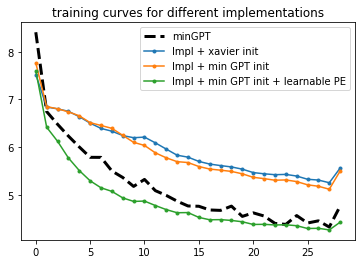

In [80]:
window = 50
plot_avg(loss_histories['mingpt_n2_h8_d512_c64'], window, 'k--', linewidth=3)
plot_avg(loss_histories['autoreg_n2_h8_d512_c64_wproj_xavier'], window, '.-')
plot_avg(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit'], window, '.-')
plot_avg(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe'], window, '.-')
plt.legend(['minGPT', 'Impl + xavier init', 'Impl + min GPT init', 'Impl + min GPT init + learnable PE'])
plt.title('training curves for different implementations')

### Data periodicity

There is some strange periodicity in the loss function which suggest that the data is not uniformly distributed. Because the data came in a single file, we built an iterator-based dataset which does not enable shuffling. This was fixed in the `WMT14Mixing` class.

(0.0, 500.0)

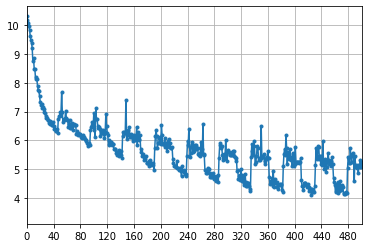

In [42]:
plt.figure()
plt.grid(which='both')
plt.xticks(range(0, 1400, 40))
window = 1
plot_avg(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe'], window, '.-')
plt.xlim([0, 500])

In [43]:
def read_line_at_batch(batch_id):
    line_num = batch_id * batch_size
    with open(data.TRAIN_PATH_EN, 'r', encoding='utf-8') as f:
        f.seek(train_dataset.en_linebreaks[line_num], 0)
        print(f.readline())

In [47]:
print('hard line')
read_line_at_batch(300)
print('easy line')
read_line_at_batch(360)

hard line
 of soldiers , I tell the girls to get out of the car .

easy line
 town .



We see that some lines are mostly not in English 

In [48]:
print('hard line')
read_line_at_batch(160) # hard
print('easy line')
read_line_at_batch(200) # easy

hard line
ay at the Pousadas de Compostela Hotel Airas Nunes ?

easy line
t be tempted to walk back to your hotel unless you are close by .



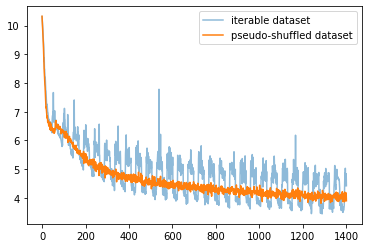

In [79]:
plt.plot(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe'], alpha=.5)
plt.plot(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle'])
plt.legend(['iterable dataset', 'pseudo-shuffled dataset'])

Previous experiments show that gradient clipping makes little difference 

## Analysis of large model (n = 8)
trained for 1 epoch only due to time/ compute constraints

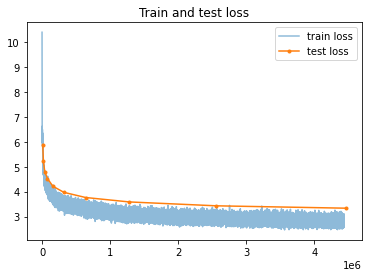

In [78]:
plt.plot(*zip(*loss_histories['autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle']['train_loss']), alpha=.5)
plt.plot(*zip(*loss_histories['autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle']['test_loss']), '.-')
plt.title('Train and test loss')
plt.legend(['train loss', 'test loss'])

## Sampling

The larger model is slightly better than the smaller model but both are very, very far from current sota

In [100]:
model_autoreg.load_state_dict(
    torch.load(
        'saved_models/autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle/1400'
    ))

<All keys matched successfully>

In [212]:
importlib.reload(utils)
utils.sample_autoregressive(model_autoreg, '', 10, dataset_config)

b'The hotel offers cost old all solders with a'

In [211]:
utils.sample_autoregressive(mgmodel, '', 10, dataset_config)

b'When would you like to stay at the Gift'

In [85]:
utils.sample_autoregressive(model_autoreg_large, '', 20, dataset_config)

b'We consider that the deficit has to do away with the revenues from fossil fu'

In [102]:
utils.sample_autoregressive(model_autoreg, 'The big white dog', 20, dataset_config)

b'The big white dog are twinnesses to the authority where his transport is some otherone being close to'

In [109]:
utils.sample_autoregressive(model_autoreg_large, 'The big white dog', 20, dataset_config)

b'The big white dog was amazing white on the stone site of The North Neckland , following'

In [111]:
utils.sample_autoregressive(model_autoreg, 'My favorite food is ', 20, dataset_config)

b'My favorite food is co release . closedness .\n'

In [110]:
utils.sample_autoregressive(model_autoreg_large, 'My favorite food is ', 20, dataset_config)

b'My favorite food is either a smoke bag of roulette or a glass of Alsa , though'